In [1]:
!pip install sentencepiece transformers[torch] bertviz datasets accelerate >=0.21.0

zsh:1: no matches found: transformers[torch]


In [2]:
!pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp313-cp313-macosx_26_0_arm64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


# Attention and self-attention

Seq2Seq 모델에서 사용되는 Bahdanau Attention 메커니즘을 구현한 클래스입니다.
Decoder의 현재 hidden state와 Encoder의 모든 출력을 입력받아, 각 입력 시점에 대한 attention weight를 계산하고, 이를 가중합하여 context vector를 생성합니다.
`W1`과 `W2`로 encoder outputs와 hidden state를 각각 변환한 뒤 더하고, `tanh` 활성화 함수를 거쳐 `V`로 스칼라 점수를 계산하며, softmax로 정규화하여 attention weight(가중치 합=1)를 얻습니다.
최종 context vector는 attention weight로 가중평균한 encoder outputs이며, decoder가 번역/생성 시 입력 시퀀스의 어느 부분에 집중할지 동적으로 결정하여 긴 문장에서도 정보 손실을 방지합니다.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        hidden_with_time_axis = hidden.unsqueeze(1)  # Adds a time dimension
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden_with_time_axis)))
        attention_weights = F.softmax(score, dim=0)  # Softmax over the sequence length dimension
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=0)  # Sum weighted encoder outputs
        return context_vector, attention_weights

# Define dimensions
hidden_size = 128
seq_length = 10
batch_size = 1

# Initialize attention, generate random encoder output
attention = BahdanauAttention(hidden_size)
encoder_outputs = torch.randn(seq_length, batch_size, hidden_size)
hidden = torch.randn(batch_size, hidden_size)

# Compute context vector and attention weights
context_vector, attention_weights = attention(hidden, encoder_outputs)

# Display the results
print("Context Vector:", context_vector)
print("Attention Weights:", attention_weights.squeeze())

Context Vector: tensor([[-0.1148,  0.3639,  0.3482,  0.3035,  0.4069, -0.0308,  0.0279,  0.0187,
         -0.6987, -0.3836, -0.2050,  0.4189, -0.6536, -0.7263,  0.6286,  0.4941,
         -0.0419, -0.3289,  0.4248, -0.0436,  0.1252, -0.4137, -0.4599, -0.5276,
         -0.4500,  0.0689, -0.2975, -0.1565,  0.0954, -0.2271, -0.1604,  0.0947,
          0.2097,  0.0271,  0.5227, -0.4443,  0.0473, -0.7738, -0.3786,  0.1544,
         -0.6913,  0.0974,  0.4946, -0.3937, -0.3443, -0.0657,  0.1264,  0.5626,
         -0.7325, -0.1055,  0.5204, -0.0445, -0.0454, -0.1234,  0.0911, -0.4523,
         -0.1366,  0.0408,  0.4391, -0.1946, -0.0372, -0.1861, -0.1653, -0.1096,
         -0.1248,  0.5576, -0.2662,  0.1311, -0.0070, -0.6516,  0.3742, -0.0344,
          0.0583,  0.1170, -0.3382, -0.1327,  0.1711, -0.0526,  0.2766, -0.5058,
         -0.4044, -0.5897,  0.2126, -0.4138, -0.5036,  0.0957,  0.4271, -0.2926,
          0.6459,  0.1624, -0.1021,  0.9154, -0.4832,  0.0946,  0.3674,  0.3018,
         -0.

Self-Attention 메커니즘을 구현한 클래스로, 입력 시퀀스의 각 위치가 다른 모든 위치와의 관계를 학습합니다.
입력 x(seq_length × embed_size)를 학습 가능한 파라미터 행렬 queries, keys, values와 곱하여 Q, K, V 행렬을 생성하고, Q와 K의 내적으로 각 토큰 쌍 간 유사도를 계산합니다.
`attention_scores = Q @ K.T / sqrt(embed_size)`로 scaled dot-product attention을 수행하며, 스케일링은 큰 내적 값으로 인한 gradient vanishing을 방지하고, softmax로 정규화하여 각 토큰이 다른 토큰들에 얼마나 집중할지 확률 분포를 얻습니다.
최종적으로 attention_probs와 V를 곱하여 가중합된 값을 반환하며, 예를 들어 "The cat sat on the mat"에서 "cat"이 "sat"과 "mat"에 높은 attention을 줘 문맥 정보를 통합합니다.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dimensions and sample data
embed_size = 64
seq_length = 10

queries_size, key_size, value_size = 32, 32, 64

class SelfAttention(nn.Module):
    def __init__(self, embed_size, queries_size, key_size, value_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.queries = torch.nn.Parameter(torch.rand(queries_size, embed_size))
        self.keys = torch.nn.Parameter(torch.rand(key_size, embed_size))
        self.values = torch.nn.Parameter(torch.rand(value_size, embed_size))

    def forward(self, x):
        Q = self.queries.matmul(x.T).T  # Query matrix
        K = self.keys.matmul(x.T).T     # Key matrix
        V = self.values.matmul(x.T)   # Value matrix

        # scaled dot product
        attention_scores = torch.matmul(Q, K.T) / (self.embed_size ** 0.5)

        attention_probs = F.softmax(attention_scores, dim=-1)
        print(attention_probs.shape), print(V.shape)
        attended_values = torch.matmul(attention_probs, V.T)
        return attended_values, attention_probs

# Dimensions and sample data
embed_size = 64
seq_length = 10
batch_size = 1

x = torch.randn(seq_length, embed_size)


attention = SelfAttention(embed_size, queries_size, key_size, value_size)
attended_values, attention_probs = attention(x)

print("Attended Values shape:", attended_values.shape)
print("Attention Probabilities shape:", attention_probs.shape)


torch.Size([10, 10])
torch.Size([64, 10])
Attended Values shape: torch.Size([10, 64])
Attention Probabilities shape: torch.Size([10, 10])


Transformer의 핵심인 Multi-Head Self-Attention을 구현한 클래스로, 여러 개의 attention head를 병렬로 실행하여 다양한 관점에서 문맥을 포착합니다.
embed_size(128)를 num_heads(8)로 나눠 각 head가 head_dim(16) 크기의 부분 공간에서 독립적으로 attention을 수행하며, 이를 통해 단어 간 구문적/의미적/위치적 관계를 동시에 학습할 수 있습니다.
`einsum("nqhd,nkhd->nhqk")`로 각 head별로 Q와 K의 내적을 효율적으로 계산하고, softmax로 attention weight를 얻은 뒤, `einsum("nhql,nlhd->nqhd")`로 V와 가중합하여 각 head의 출력을 생성합니다.
모든 head의 출력을 concat하여 원래 embed_size로 복원하고 `fc_out`으로 최종 변환하며, 예를 들어 한 head는 주어-동사 관계에, 다른 head는 명사-형용사 관계에 집중하는 식으로 다양한 언어 패턴을 포착합니다.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embed size must be divisible by number of heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, queries):
        N = queries.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Split the embedding into self.num_heads different pieces
        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.num_heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        QK_product = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])


        attention = torch.softmax(QK_product / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.num_heads * self.head_dim)
        out = self.fc_out(out)
        return out

# Example usage
embed_size = 128  # Embedding size
num_heads = 8    # Number of heads in Multi-Head Attention
seq_length = 10  # Length of the sequence
batch_size = 1   # Batch size


model = MultiHeadSelfAttention(embed_size, num_heads)

x = torch.randn(batch_size, seq_length, embed_size)

out = model(x, x, x)
print("Output Shape:", out.shape)


Output Shape: torch.Size([1, 10, 128])


# The transformer

Transformer에서 단어의 순서 정보를 임베딩에 추가하기 위한 Positional Encoding을 생성하는 함수입니다.
Self-Attention은 순서를 고려하지 않으므로(permutation invariant), sin/cos 함수를 사용해 각 위치(position)에 고유한 벡터를 할당하여 "첫 번째 단어", "두 번째 단어" 등의 위치 정보를 모델에 제공합니다.
짝수 차원에는 `sin(position / 10000^(2i/d_model))`, 홀수 차원에는 `cos(position / 10000^(2i/d_model))`를 사용하며, 서로 다른 주파수로 진동하는 파형을 만들어 각 위치가 unique한 패턴을 가집니다.
sin/cos를 사용하는 이유는 상대적 위치 관계를 선형 변환으로 표현할 수 있고(PE(pos+k)를 PE(pos)의 선형 결합으로 표현 가능), 임의 길이의 시퀀스에도 일반화되며, 히트맵 시각화에서 물결 무늬 패턴이 나타나는 것을 확인할 수 있습니다.

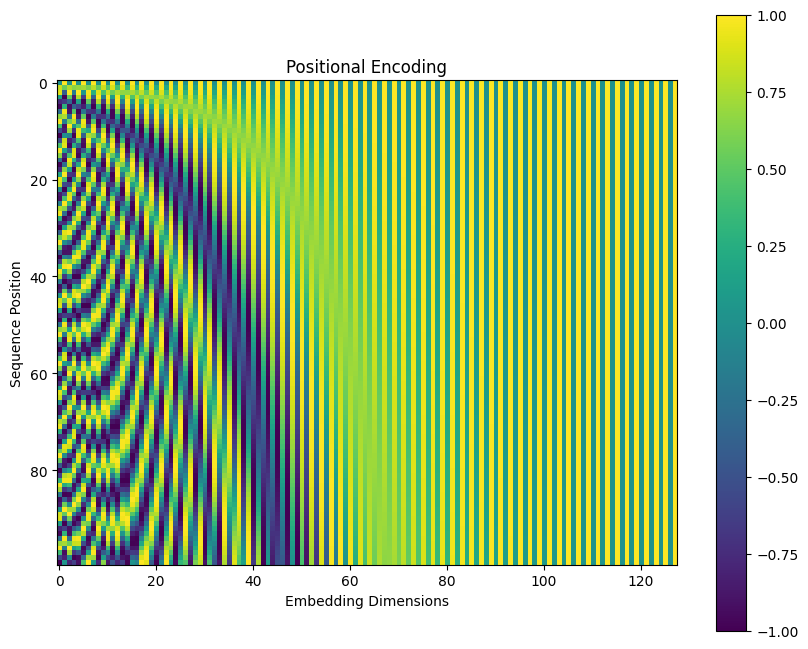

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(seq_length, d_model, device='cpu'):
    """
    Generates a matrix of positional encodings.
    Returns:
    torch.Tensor: A tensor of shape (seq_length, d_model) containing the positional encodings.
    """
    position = torch.arange(seq_length).unsqueeze(1).float().to(device)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model)).to(device)

    pe = torch.zeros(seq_length, d_model).to(device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    return pe

# Parameters
seq_length = 100  # Sequence length
d_model = 128     # Embedding dimension

pos_encoding = positional_encoding(seq_length, d_model)

plt.figure(figsize=(10, 8))
plt.imshow(pos_encoding.numpy(), cmap='viridis')
plt.colorbar()
plt.title("Positional Encoding")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Sequence Position")
plt.savefig('positional_encoding.jpg', format='jpeg')
plt.show()


In [9]:
import numpy as np, sys, os
print("Python:", sys.version)
print("NumPy version:", np.__version__)
print("NumPy file:", np.__file__)

Python: 3.13.7 (v3.13.7:bcee1c32211, Aug 14 2025, 19:10:51) [Clang 16.0.0 (clang-1600.0.26.6)]
NumPy version: 1.26.4
NumPy file: /Users/kwon/PyTorch.training/Modern-AI-Agents/.venv/lib/python3.13/site-packages/numpy/__init__.py


BERT 토크나이저로 텍스트를 WordPiece 토큰으로 분리하고, 각 토큰을 고유한 색상으로 배경 칠하여 HTML로 시각화하는 함수입니다.
`tokenizer.tokenize()`로 단어를 subword 단위로 분리하며(예: "playing" → "play", "##ing"), 동일한 토큰은 hash 함수로 항상 같은 색상을 할당받아 반복되는 단어를 쉽게 식별할 수 있습니다.
BERT의 토크나이제이션 방식을 시각적으로 이해할 수 있으며, 예를 들어 "be"가 여러 번 나타나면 모두 같은 색으로 표시되고, "##ing" 같은 subword 토큰이 어떻게 생성되는지 확인할 수 있습니다.
이는 교육용 시각화 도구로, BERT가 단어를 subword로 분해하여 처리하는 원리를 직관적으로 보여줍니다.

In [10]:
from transformers import BertTokenizer
from IPython.display import HTML
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_tokenize_and_color(text, tokenizer ):
    text = ' '.join(text)
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    colored_text = ""
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    for token in tokens:
        color = colors[hash(token) % len(colors)]
        token_html = f'<span style="background-color:{color}">{token}</span>'
        colored_text += token_html + ' '

    return HTML(colored_text)

# Example usage
text = ['To be or not to be, that is the question.',
'Whether tis nobler in the mind to suffer',
'The slings and arrows of outrageous fortune',
'Or to take arms against a sea of troubles,',
'And by opposing, end them. To die, to sleep',
'No more, and by a sleep to say we end,',
'The heartache and the thousand natural shocks',
'That flesh is heir to, tis a consummation',
'Devoutly to be wished.']
bert_tokenize_and_color(text, tokenizer)


# Visualize internal mechanism

BERT 모델의 모든 레이어와 attention head에서 각 토큰이 다른 토큰에 얼마나 집중하는지 시각화하는 코드입니다.
두 문장을 `[CLS] sentence_a [SEP] sentence_b [SEP]` 형태로 입력하고, `output_attentions=True`로 모든 attention weight를 추출하며, `token_type_ids`로 첫 번째와 두 번째 문장을 구분합니다.
`head_view()`는 BertViz 라이브러리를 사용해 인터랙티브 시각화를 생성하며, 각 레이어의 12개 head별로 토큰 간 attention 연결선을 보여줍니다(선이 굵을수록 높은 attention).
예를 들어 "be"와 "eat"이 유사한 구조로 attention을 받는지, 또는 특정 head가 구문 구조(주어-동사)에 집중하는지, 다른 head는 의미적 유사성에 집중하는지 등을 시각적으로 분석할 수 있습니다.

In [12]:
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "To be or not to be"
sentence_b = " To eat or not to eat the snack"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [13]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

GPT-2 언어 모델이 "To be or not to" 다음에 올 가능성이 높은 상위 10개 단어와 그 확률을 막대 그래프로 시각화하는 코드입니다.
모델의 마지막 토큰에 대한 logits(raw 출력 점수)를 softmax로 변환하여 전체 어휘집(약 50,000개 단어)에 대한 확률 분포를 얻고, `torch.topk()`로 가장 높은 확률 10개를 추출합니다.
`tokenizer.convert_ids_to_tokens()`로 인덱스를 단어로 변환하고, GPT-2 토크나이저의 특수 기호 'Ġ'(공백 표시)를 제거하여 가독성을 높입니다.
예를 들어 "be"가 가장 높은 확률을 보일 것이며, 이는 GPT-2가 셰익스피어 대사 "To be or not to be"를 학습 데이터에서 본 적이 있어 문맥을 이해하고 있음을 의미합니다.

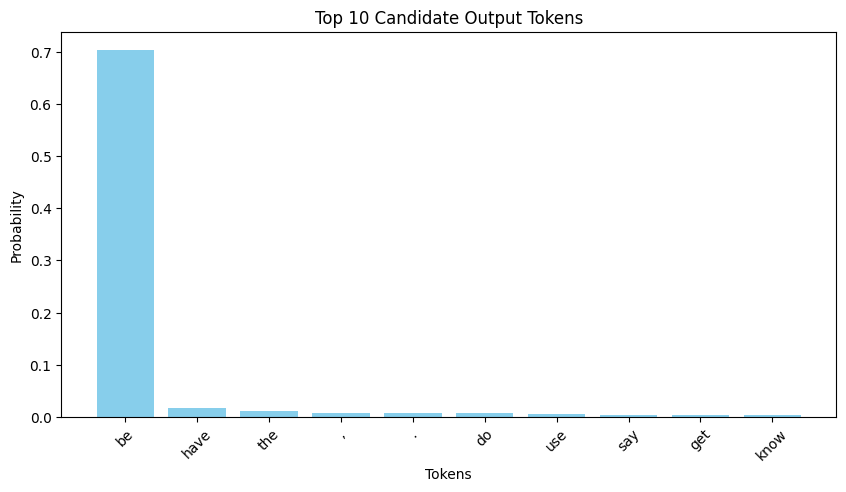

In [14]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Tokenize the input text and generate output
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
inputs = tokenizer("To be or not to", return_tensors="pt")
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Get logits from the last layer
# Apply softmax to convert logits into probabilities
logits = outputs.logits
last_token_logits = logits[0, -1, :]
probabilities = torch.softmax(last_token_logits, dim=-1)

# Get the top 10 tokens and their probabilities
top_probabilities, top_indices = torch.topk(probabilities, 10)

top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
top_tokens = [i.replace('Ġ', '') for i in top_tokens]

plt.figure(figsize=(10, 5))
plt.bar(top_tokens, top_probabilities.numpy(), color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Top 10 Candidate Output Tokens')
plt.xticks(rotation=45)
plt.savefig('Top 10 Candidate.jpg', bbox_inches='tight', format='jpeg')
plt.show()


Gradient × Input 기법으로 입력 토큰들이 특정 출력 단어("question") 예측에 얼마나 기여했는지 중요도를 계산하고 시각화하는 코드입니다.
`embeddings.requires_grad = True`로 gradient 추적을 활성화하고, 타겟 단어 "question"의 logit에 대해 `backward()`를 수행하여 각 입력 임베딩의 gradient를 계산합니다.
`grad_input = embeddings.grad * embeddings`로 gradient와 입력값을 element-wise 곱하여 attribution score를 구하며, 이는 각 토큰이 출력에 미치는 영향의 방향과 크기를 나타냅니다.
임베딩 차원을 합산하고 정규화하여 막대 그래프로 표시하며, 예를 들어 "To", "be", "that"이 높은 중요도를 보이면 모델이 이 단어들을 주요 문맥 단서로 사용해 "question"을 예측했음을 의미하며, 이는 모델의 의사결정 과정을 해석하는 explainable AI 기법입니다.

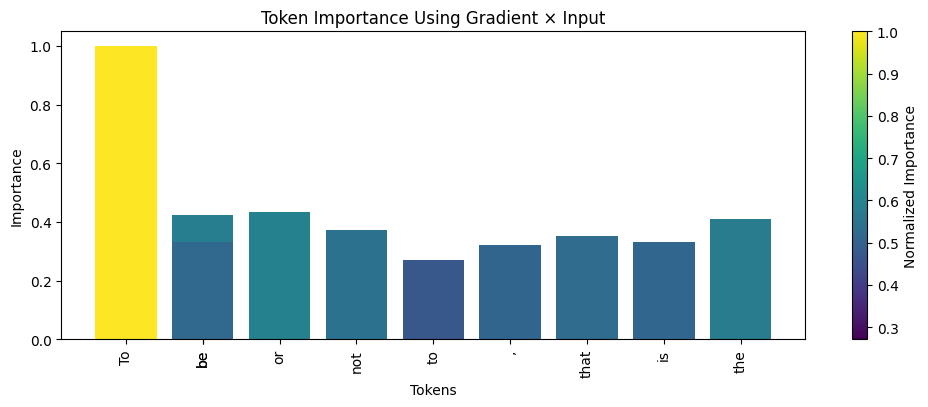

In [15]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
inputs = tokenizer("To be or not to be, that is the", return_tensors="pt")
input_ids = inputs["input_ids"]

# Get embeddings and clone to make them a leaf in the graph
embeddings = model.transformer.wte(input_ids)
embeddings = embeddings.clone().detach()
embeddings.requires_grad = True

# Perform forward pass using embeddings
model.eval()
outputs = model(inputs_embeds=embeddings)
last_token_logits = outputs.logits[0, -1, :]


target_id = tokenizer.convert_tokens_to_ids('question')
target_logit = last_token_logits[target_id]

# Gradient × Input calculation
target_logit.backward()
grad_input = embeddings.grad * embeddings

# Sum of absolute gradient input values across embedding dimensions
importance_scores = grad_input.abs().sum(dim=-1).squeeze()

# Normalize scores for better visualization
importance_scores /= importance_scores.max()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
tokens = [i.replace('Ġ', '') for i in tokens]

fig, ax = plt.subplots(figsize=(12, 4))
colors = plt.cm.viridis(importance_scores.detach().numpy())
bars = ax.bar(tokens, importance_scores.detach().numpy(), color=colors)
ax.set_xlabel('Tokens')
ax.set_ylabel('Importance')
ax.set_title('Token Importance Using Gradient × Input')
ax.set_xticks(tokens)
ax.set_xticklabels(tokens, rotation=90)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=importance_scores.min(), vmax=importance_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Normalized Importance')
plt.savefig('Top tokens.jpg', bbox_inches='tight', format='jpeg')
plt.show()


GPT-2 모델의 각 레이어에서 최종 상위 5개 토큰의 예측 순위가 어떻게 변화하는지 히트맵으로 시각화하는 코드입니다.
`output_hidden_states=True`로 모든 레이어(6개)의 hidden state를 추출하고, 각 레이어의 마지막 토큰 표현을 `lm_head`에 통과시켜 해당 레이어 시점에서의 예측 logits을 계산합니다.
최종 출력에서 상위 5개 토큰을 선택한 뒤, 각 레이어에서 이 토큰들이 몇 번째 순위였는지 추적하여 행렬로 구성하며, 낮은 순위(1, 2, 3)는 빨간색, 높은 순위는 파란색으로 표시됩니다.
예를 들어 "be"가 초기 레이어에서는 29위였다가 후반 레이어에서 1위로 상승하는 패턴을 보이면, 모델이 레이어를 거치며 점진적으로 문맥을 이해하고 정답에 수렴하는 과정을 시각적으로 확인할 수 있습니다.

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


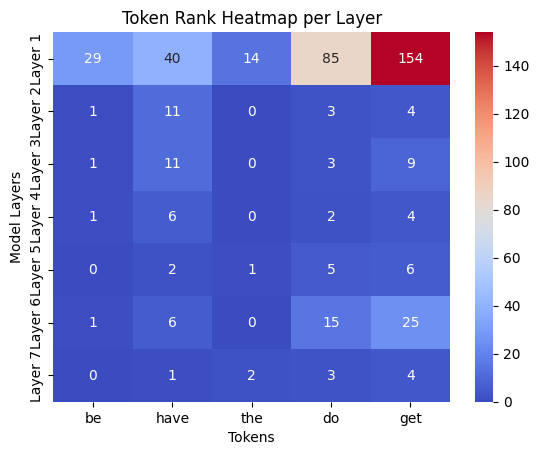

In [16]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2', output_hidden_states=True)
input_ids = tokenizer.encode('to be or not to', return_tensors='pt')

# Predict logits for the next token
with torch.no_grad():
    outputs = model(input_ids)
    last_hidden_state = outputs.hidden_states[-1][0, -1, :]
    logits = model.lm_head(last_hidden_state)

# Select top 5 tokens
_, top_indices = torch.topk(logits, 5)
top_tokens = tokenizer.convert_ids_to_tokens(top_indices)

# Function to get ranks for the selected top tokens across each layer
def get_ranks(hidden_states, top_indices):
    ranks = np.zeros((len(hidden_states), len(top_indices)), dtype=int)
    for i, state in enumerate(hidden_states):
        logits = model.lm_head(state[0, -1, :])
        sorted_indices = torch.argsort(logits, descending=True)
        for j, token_idx in enumerate(top_indices):
            rank = (sorted_indices == token_idx).nonzero(as_tuple=True)[0].item()
            ranks[i, j] = rank
    return ranks

# Compute ranks
ranks_matrix = get_ranks(outputs.hidden_states, top_indices)
top_tokens = [i.replace('Ġ', '') for i in top_tokens]

sns.heatmap(ranks_matrix, annot=True, cmap='coolwarm', fmt="d", xticklabels=top_tokens, yticklabels=[f'Layer {i+1}' for i in range(len(outputs.hidden_states))])
plt.title('Token Rank Heatmap per Layer')
plt.xlabel('Tokens')
plt.ylabel('Model Layers')
plt.show()


DistilGPT-2 모델의 각 레이어(6개)에서 긍정/부정 리뷰가 얼마나 분리되는지 t-SNE로 시각화하여 레이어별 표현 학습을 분석하는 코드입니다.
1000개 IMDB 리뷰를 입력하고 `output_hidden_states=True`로 모든 레이어의 hidden state를 추출하며, 각 리뷰의 모든 토큰 표현을 평균(mean pooling)하여 문서 레벨 임베딩을 생성합니다.
각 레이어별로 1000개 리뷰의 hidden state를 t-SNE로 2차원으로 축소하고, 긍정(빨강)과 부정(파랑)을 색상으로 구분하여 6개 subplot에 표시합니다.
초기 레이어에서는 감정이 섞여있다가 후반 레이어로 갈수록 긍정/부정 클러스터가 명확히 분리되는 패턴을 보이면, 모델이 깊은 레이어에서 감정 정보를 점진적으로 학습함을 의미하며, 이는 사전학습된 GPT-2도 어느 정도 감정 구분 능력을 가지고 있음을 보여줍니다.

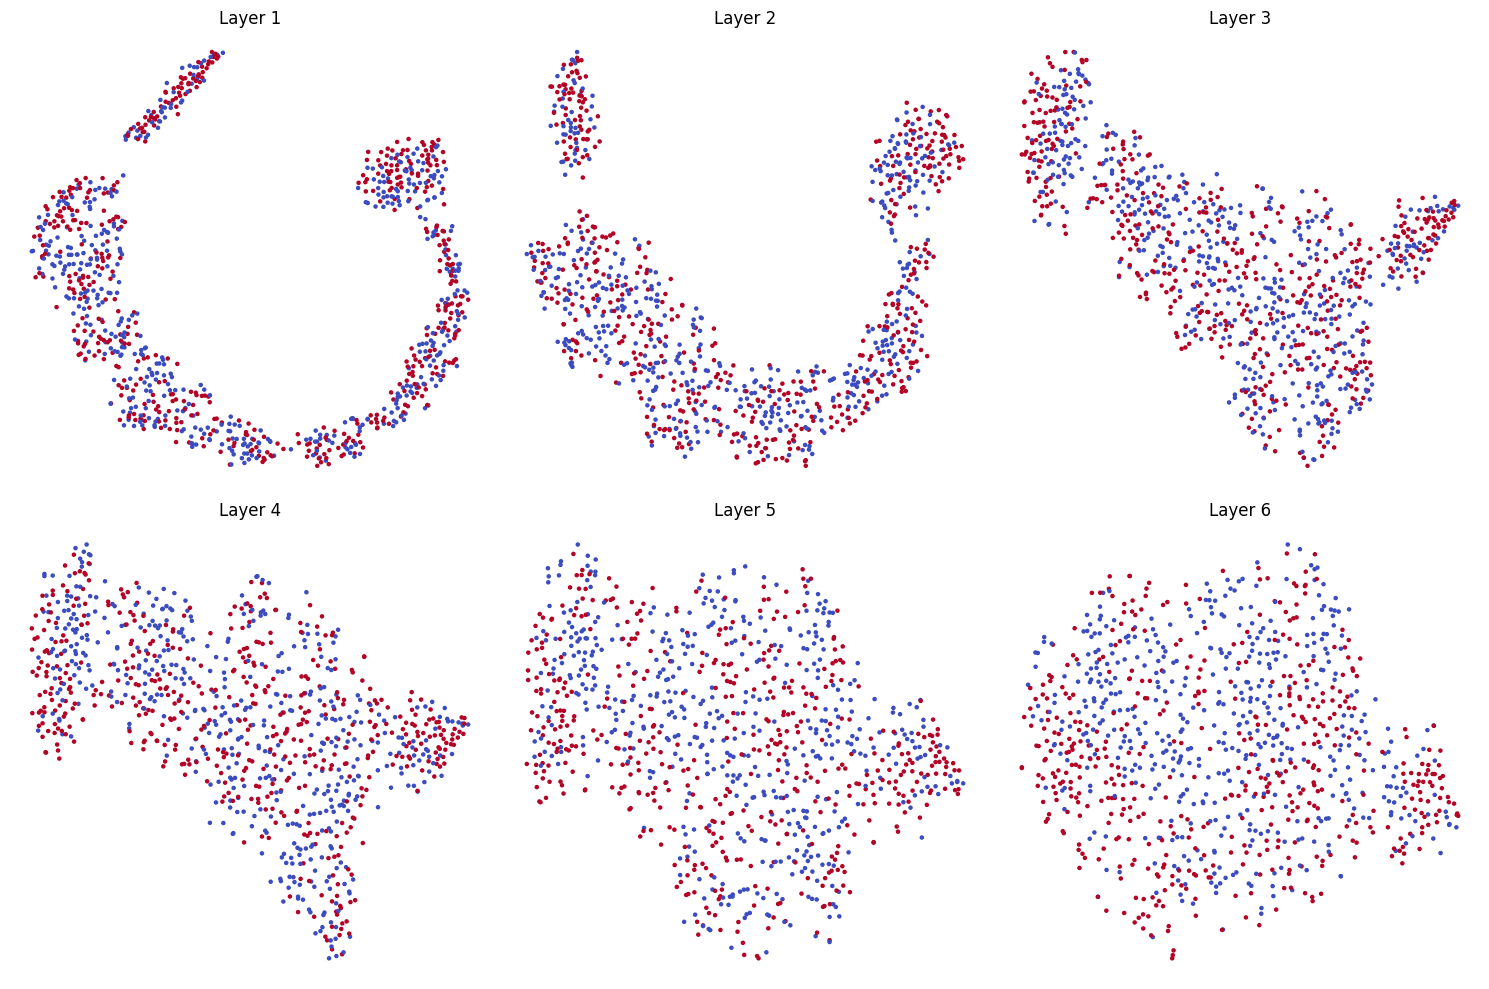

In [18]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the DataFrame
try:
    df = pd.read_csv("IMDB Dataset.csv")
except:
    !wget https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
    !unzip IMDB.zip?raw=true
    df = pd.read_csv("IMDB Dataset.csv")

df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df = df.iloc[:1000]

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Function to get hidden states
def get_hidden_states(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**tokens)
    hidden_states = outputs.hidden_states
    return [hidden_state.squeeze(0).mean(dim=0) for hidden_state in hidden_states]


df['hidden_states'] = df['review'].apply(get_hidden_states)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(6):  # Assuming DistilGPT2 has 6 layers
    layer_hidden_states = torch.stack(df['hidden_states'].map(lambda x: x[i]).tolist())
    reducer = TSNE(n_components=2, random_state=42)
    tsne_result = reducer.fit_transform(layer_hidden_states.detach().numpy())
    axs[i].scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['sentiment'], cmap='coolwarm', s=5)
    axs[i].set_title(f'Layer {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# Application of the transformer

## Fine tuning

IMDB 리뷰 데이터 2000개를 로드하고 DistilBERT 모델 파인튜닝을 위해 전처리 및 토큰화하는 코드입니다.
감정 레이블을 positive=1, negative=0으로 인코딩하고, 90% train / 10% validation으로 분할하며, DistilBERT 토크나이저로 WordPiece 토큰화를 수행합니다.
`tokenize_function()`에서 `max_length=128`로 길이를 제한하고(긴 리뷰는 잘림, 짧은 리뷰는 패딩), `padding="max_length"`로 모든 샘플을 동일한 길이로 맞춥니다.
`Dataset.from_pandas()`로 HuggingFace Datasets 형식으로 변환하고, `map(batched=True)`로 배치 단위로 효율적으로 토큰화하여 Trainer API로 바로 학습할 수 있는 형태로 준비합니다.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from datasets import Dataset

try:
    df=pd.read_csv("IMDB Dataset.csv")
except:
    !wget https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
    !unzip IMDB.zip?raw=true
    df=pd.read_csv("IMDB Dataset.csv")
df = df.iloc[:2000,:]

# Convert labels to numerical format
label_dict = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_dict)

# Split the data and tokenize them
train_df, val_df = train_test_split(df, test_size=0.1)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)



Map: 100%|██████████| 200/200 [00:00<00:00, 355.61 examples/s]


In [3]:
import wandb
wandb.init(mode="disabled")

사전학습된 DistilBERT 모델을 IMDB 감정 분류 태스크에 파인튜닝하고 평가하는 코드입니다.
`DistilBertForSequenceClassification`은 DistilBERT에 분류용 linear layer를 추가한 모델이며, `num_labels=2`로 이진 분류(긍정/부정)를 설정합니다.
`TrainingArguments`로 3 epoch 학습, batch size 8, warmup 500 step(초기 learning rate를 점진적으로 증가), weight decay 0.01(L2 regularization), epoch마다 validation 평가를 설정합니다.
`Trainer` API는 HuggingFace의 high-level 학습 인터페이스로, gradient accumulation, mixed precision, checkpoint 저장 등을 자동으로 처리하며, `trainer.train()`으로 학습하고 `trainer.evaluate()`로 validation loss를 출력합니다.

In [4]:
from transformers import DistilBertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    # evaluation_strategy="epoch"      # evaluate each epoch
    eval_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

results = trainer.evaluate()
print(results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/kwon/PyTorch.training/Modern-AI-Agents/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


/Users/kwon/PyTorch.training/Modern-AI-Agents/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.524873673915863, 'eval_runtime': 3.2558, 'eval_samples_per_second': 61.429, 'eval_steps_per_second': 3.993, 'epoch': 3.0}


파인튜닝된 DistilBERT 모델을 validation set에 적용하여 예측을 생성하고 confusion matrix로 성능을 시각화하는 코드입니다.
`trainer.predict()`로 validation set의 모든 샘플에 대한 logits(2차원, negative/positive 점수)를 얻고, `np.argmax()`로 더 높은 점수의 클래스를 최종 예측으로 선택합니다.
`confusion_matrix()`로 True Negative, False Positive, False Negative, True Positive를 2×2 행렬로 구성하며, 대각선이 정확한 예측, 비대각선이 오분류를 나타냅니다.
히트맵으로 시각화하여 모델이 긍정을 부정으로 잘못 분류하는지(False Negative), 또는 그 반대인지(False Positive) 직관적으로 파악할 수 있으며, 파인튜닝 후 대부분의 샘플이 대각선에 위치하면 성공적인 학습을 의미합니다.

/Users/kwon/PyTorch.training/Modern-AI-Agents/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


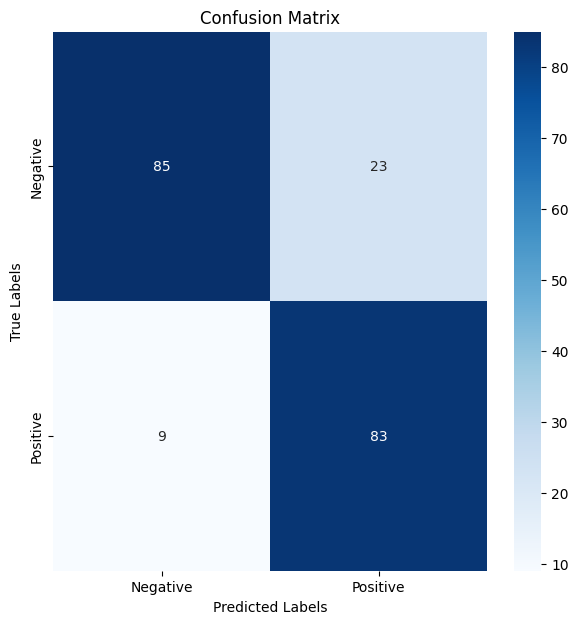

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Generate predictions
predictions = trainer.predict(val_dataset)
# Extract logits
logits = predictions.predictions
# Convert logits to class labels
predicted_labels = np.argmax(logits, axis=-1)
actual_labels = val_dataset['label']

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('fine tuning confusion matrix.jpg', bbox_inches='tight', format='jpeg')
plt.show()


## Knowledge distillation

Knowledge Distillation을 위해 Teacher 모델(BERT)을 학습시킬 데이터를 준비하는 코드입니다.
이전 파인튜닝 예제와 동일하게 IMDB 2000개 샘플을 로드하고 전처리하지만, 이번에는 `BertTokenizer`를 사용하여 더 큰 BERT 모델(110M 파라미터)용으로 토큰화합니다.
Knowledge Distillation은 큰 Teacher 모델(BERT)의 지식을 작은 Student 모델(DistilBERT, 66M 파라미터)로 전달하는 기법으로, Teacher를 먼저 학습시켜 높은 성능을 달성한 뒤 그 예측을 Student가 모방하도록 합니다.
이 코드는 Teacher 모델 학습의 첫 단계이며, 다음 단계에서 BERT를 파인튜닝하고, 그 출력(soft labels)을 이용해 DistilBERT를 학습시켜 모델 크기를 줄이면서도 성능을 유지합니다.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification
from datasets import Dataset
from transformers import Trainer, TrainingArguments

try:
    df=pd.read_csv("IMDB Dataset.csv")
except:
    !wget https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
    !unzip IMDB.zip?raw=true
df = df.iloc[:2000,:]

label_dict = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_dict)

# Split the data
train_df, val_df = train_test_split(df, test_size=0.1)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 200/200 [00:00<00:00, 298.38 examples/s]


Knowledge Distillation의 Teacher 모델로 사용할 BERT를 IMDB 감정 분류 태스크에 파인튜닝하는 코드입니다.
`BertForSequenceClassification`은 110M 파라미터를 가진 큰 모델로, 높은 정확도를 달성할 수 있지만 추론 속도가 느리고 메모리를 많이 사용합니다.
DistilBERT와 동일한 학습 설정(3 epoch, batch size 8)으로 학습하며, 이 Teacher 모델은 나중에 Student 모델(DistilBERT)을 가르치기 위한 "지식의 원천" 역할을 합니다.
Teacher 모델이 출력하는 soft labels(확률 분포)는 hard labels(0 또는 1)보다 더 풍부한 정보를 담고 있으며, 예를 들어 [0.1, 0.9]는 "약간 애매하지만 긍정"이라는 뉘앙스를 전달하여 Student가 더 효과적으로 학습할 수 있습니다.

In [7]:
teacher_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results_teacher',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    # evaluation_strategy="epoch"
    eval_strategy="epoch"
)

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.
/Users/kwon/PyTorch.training/Modern-AI-Agents/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


/Users/kwon/PyTorch.training/Modern-AI-Agents/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


TrainOutput(global_step=675, training_loss=0.282836185031467, metrics={'train_runtime': 780.1987, 'train_samples_per_second': 6.921, 'train_steps_per_second': 0.865, 'total_flos': 355199924736000.0, 'train_loss': 0.282836185031467, 'epoch': 3.0})

Knowledge Distillation의 Student 모델로 사용할 DistilBERT를 초기화하고, 커스텀 학습 루프를 위한 DataLoader를 준비하는 코드입니다.
`DistilBertForSequenceClassification`은 BERT의 40% 크기(66M 파라미터)이지만 성능은 97% 수준을 유지하도록 설계된 경량 모델입니다.
Trainer API 대신 수동 학습 루프를 사용하기 위해 `DataLoader`를 생성하며, `DefaultDataCollator`는 배치 내 샘플들을 적절히 패딩하고 텐서로 변환합니다.
이렇게 준비된 Student 모델은 다음 단계에서 Teacher 모델의 soft labels(확률 분포)를 타겟으로 학습하며, KL Divergence로 두 분포 간 차이를 최소화하여 Teacher의 지식을 증류(distillation)받습니다.

In [8]:
student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
from torch.utils.data import DataLoader
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors="pt")
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Knowledge Distillation을 수행하는 커스텀 학습 루프로, Student 모델이 Teacher 모델의 출력 분포를 모방하도록 학습시키는 코드입니다.
`distillation_loss()` 함수는 KL Divergence로 두 모델의 logits 분포 차이를 계산하며, `temperature=2.0`은 확률 분포를 "부드럽게(soften)" 만들어 더 많은 정보를 전달합니다(예: [0.01, 0.99] → [0.1, 0.9]).
매 배치마다 Teacher 모델(`torch.no_grad()`)과 Student 모델로 동일 입력을 forward pass하고, Student의 출력이 Teacher의 출력 분포와 가까워지도록 KL Divergence를 최소화합니다.
일반 분류 학습은 hard labels(0 또는 1)만 사용하지만, distillation은 Teacher의 soft labels(확률 분포)를 사용하여 "약간 긍정에 가까운 중립" 같은 세밀한 정보까지 학습하므로, Student가 더 적은 파라미터로도 Teacher에 가까운 성능을 달성할 수 있습니다.

In [9]:
from torch.nn import KLDivLoss, functional as F
from tqdm.auto import tqdm
# from transformers import AdamW
from torch.optim import AdamW
import torch

# Prepare model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)
teacher_model.to(device)
optimizer = AdamW(student_model.parameters(), lr=5e-5)


def distillation_loss(outputs_student, outputs_teacher, temperature=2.0):
    """
    Calculate the knowledge distillation loss between the teacher and student outputs
    using KL Divergence. This function assumes that the outputs are logits.
    """
    log_prob_student = F.log_softmax(outputs_student / temperature, dim=-1)
    prob_teacher = F.softmax(outputs_teacher / temperature, dim=-1)
    # Calculate KL Divergence Loss
    loss = KLDivLoss(reduction='batchmean')(log_prob_student, prob_teacher)
    return loss


def train_epoch(model, dataloader, optimizer, device, teacher_model, temperature=2.0):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}

        with torch.no_grad():
            outputs_teacher = teacher_model(**inputs).logits

        outputs_student = model(**inputs).logits

        loss = distillation_loss(outputs_student, outputs_teacher, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, device, teacher_model, temperature=2.0):
    model.eval()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Evaluating"):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}

        with torch.no_grad():
            outputs_teacher = teacher_model(**inputs).logits
            outputs_student = model(**inputs).logits
            loss = distillation_loss(outputs_student, outputs_teacher, temperature)
            total_loss += loss.item()

    return total_loss / len(dataloader)


epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_epoch(student_model, train_dataloader, optimizer, device, teacher_model)
    print(f"Training Loss: {train_loss}")

    val_loss = validate(student_model, val_dataloader, device, teacher_model)
    print(f"Validation Loss: {val_loss}")

Epoch 1/3


Training: 100%|██████████| 225/225 [06:46<00:00,  1.81s/it]


Training Loss: 0.34720880938900844


Evaluating: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Validation Loss: 0.16110889040506804
Epoch 2/3


Training: 100%|██████████| 225/225 [04:12<00:00,  1.12s/it]


Training Loss: 0.14373923173691663


Evaluating: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Validation Loss: 0.158978186117915
Epoch 3/3


Training: 100%|██████████| 225/225 [03:44<00:00,  1.00it/s]


Training Loss: 0.07032232131188114


Evaluating: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]

Validation Loss: 0.17764196544885635


Teacher 모델(BERT)과 Student 모델(DistilBERT)의 성능을 confusion matrix로 비교하여 Knowledge Distillation의 효과를 평가하는 코드입니다.
`get_predictions()`는 validation set의 모든 배치를 순회하며 logits에서 `argmax`로 예측 클래스를 추출하고, 실제 레이블과 함께 반환합니다.
각 모델의 예측으로 confusion matrix를 생성하고, 두 개를 나란히 배치하여 Teacher와 Student의 성능 차이를 직접 비교할 수 있도록 시각화합니다.
성공적인 distillation이라면 Student의 confusion matrix가 Teacher와 유사한 패턴을 보이며, 파라미터는 40% 수준이지만 정확도는 90% 이상 유지되어 모델 경량화와 성능 보존을 동시에 달성했음을 확인할 수 있습니다.

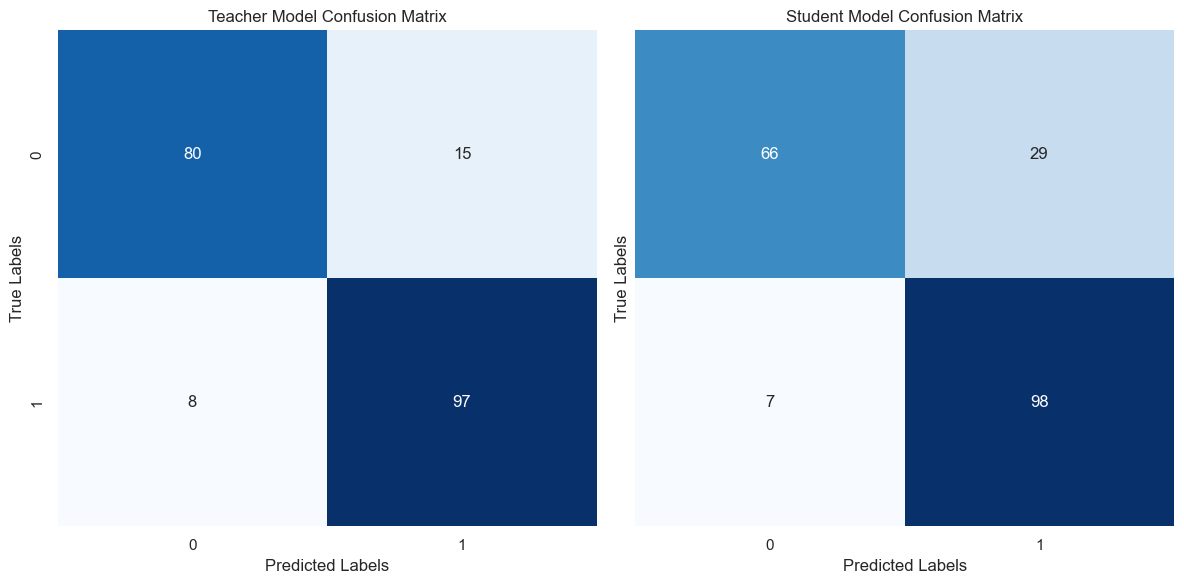

In [10]:
import torch

def get_predictions(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(batch['labels'].cpu().numpy())

    return all_true_labels, all_predictions

teacher_labels, teacher_preds = get_predictions(teacher_model, val_dataloader, device)
student_labels, student_preds = get_predictions(student_model, val_dataloader, device)

from sklearn.metrics import confusion_matrix

teacher_cm = confusion_matrix(teacher_labels, teacher_preds)
student_cm = confusion_matrix(student_labels, student_preds)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plot_confusion_matrix(teacher_cm, 'Teacher Model Confusion Matrix', ax1)
plot_confusion_matrix(student_cm, 'Student Model Confusion Matrix', ax2)

plt.tight_layout()
plt.show()
